In [1]:
# import modules

In [2]:
# import libraries
from math import * 
import math
import sympy as sy
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib widget
import trackpy as tp
import os
import seaborn as sns
import os
import pickle

from scipy import signal
from scipy.signal import find_peaks
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import fft, fftfreq
from scipy import optimize
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit 
import matplotlib.patches as patches

import sdt

import scipy.io
import pims
from scipy.ndimage import gaussian_filter
import matplotlib.patches as patches
from glob import glob
import copy
from sdt import nbui, io
import pickle
from PIL import Image


# --> Change globally the fonts of the plots:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({ 'font.sans-serif':'Arial'})
# to restore defaults use:    mpl.rc_file_defaults()

In [3]:
# Define a Gaussian function 
def gauss_func(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


def fit_gauss(hist,Swell,Swell_std):
    xdata = np.array(hist_interval(hist))
    ydata = np.array(hist[0])
    para, covariance = curve_fit(gauss_func,xdata, ydata,p0=[max(ydata),Swell,Swell_std]) 
    a = para[0] 
    x0 = para[1] 
    sigma = para[2] 
    fit_x = np.linspace(min(xdata),max(xdata),100)
    fit_y = gauss_func(fit_x,a,x0,sigma) 
    return fit_x,fit_y,para

#filter func
def filt(df, var, low, high):
    return df[(df[var]>low) & (df[var]<high)]

def plot_linfit(df,colx,coly,ax,c,al = 0.5,deg=1,label ='linear fit'):
    # make an automatic linfit through 
    # two dataframe (df) columns (colx,coly)
    # at a specific color (c) and alpha value (al)
    
    df.dropna(subset=[colx], inplace=True)
    df.dropna(subset=[coly], inplace=True)
    
    fit = np.polyfit(df[colx],df[coly],deg)
    fitx = np.linspace(min(df[colx]),max(df[colx]),1000)
    fity = np.polyval(fit,fitx)
    ax.plot(fitx,fity,alpha = al, color = c,label = label)
    return fit, fitx, fity 

    
def AFM_H_and_n(df_STORM):

    # Calculate the n intersection for the STORM data:
    # Remove identical rows
    df_res = df_STORM.copy()
    df_res['refractive_index'] = df_res['refractive_index'].apply(lambda x: int(x))
    df_res = df_res.drop_duplicates(subset=['fibril','defocus',
                                            'refractive_index'], keep='last')
    df_res = df_res.sort_values('refractive_index')


    # Choose which height measuring method you would like to take
    H_AFM_compare = df_res['H_AFM_W'].iloc[1][1]

    # make a linear fit through the datapoints:
    x_fit = df_res['refractive_index']
    y_fit = df_res['sliding_window_height']
    fit_p = np.polyfit(x_fit,y_fit,1)
    x_n = np.linspace(min(x_fit),max(x_fit),100)
    y_n = np.polyval(fit_p,x_n)

    # just for better visualisation
    fit_p = [round(j,2) for j in fit_p]

    # Calculate the intersection:
    x_intersect = (H_AFM_compare-fit_p[1])/fit_p[0]
    n_intersect = round(x_intersect/100,4)
    ROI_intersect = df_res['fibril'].iloc[0]
    
    return n_intersect,H_AFM_compare,ROI_intersect

def get_Cw(W_v,C_v):
    Cw = W_v/(W_v+C_v)
    return Cw

def calc_cw_ng(A_dry,A_wet):
    # In dry conditions:
    A_w_dry = A_dry*wv_dry
    A_c_dry = A_dry*cv_dry
    Cw_dry = get_Cw(A_w_dry,A_c_dry)
    ng_dry = get_ng(Cw_dry)

    # In wet conditions:
    A_c_wet = A_c_dry
    A_w_wet = A_wet-A_c_wet
    Cw_wet = get_Cw(A_w_wet,A_c_wet)
    ng_wet = get_ng(Cw_wet)
    
    # return the areas:
    A_dry_list = [A_c_dry,A_w_dry]
    A_wet_list = [A_c_wet,A_w_wet]
    return Cw_dry,ng_dry, Cw_wet, ng_wet, A_dry_list, A_wet_list

def get_ng(Cw,n_dry = 1.5713):
    ng = n_dry -0.1969*Cw-0.0328*(Cw)**2
    return ng

# Import the Data

In [4]:
# Load the csv file of the AFM heights
path_to_results_folder = '/Users/simonjaritz/Desktop/ANALYSIS/analysis September 2024'
df_AFM_pth = path_to_results_folder+'/df_filt.csv'
df_AFM = pd.read_csv(df_AFM_pth)

# create a new results folder
results_folder = 'Comparing_results'
if results_folder not in os.listdir():
    os.makedirs('Comparing_results')
    print('New results folder created')
else:
    print('Results folder already exists')
    
df_AFM['n_intersect'] = None
df_AFM['H_AFM_compare'] = None

Results folder already exists


In [5]:


# Read and insert the data from the STORM analysis:

ROIS = [f for f in os.listdir() if os.path.isdir(f) and f.startswith(("2_"))]

for ROI in ROIS:
    sub_folder = f'{ROI}/loc_filt_GPU_results_{ROI}/' 
    fibrils = [f for f in os.listdir(sub_folder) 
               if os.path.isdir(os.path.join(sub_folder, f)) and f.startswith("fibril_")]
    
    for fibril in fibrils:
        sub_sub_folder = os.path.join(sub_folder, fibril, f'results_ROI_{ROI}_{fibril}/')
        filename = f'ROI_{ROI}_{fibril}_result_list.pkl'
        file_path = os.path.join(sub_sub_folder, filename)
        
        filename_error = f'ROI_{ROI}_{fibril}_RI_error_results.pkl'
        file_path_error = os.path.join(sub_sub_folder, filename_error)
        
        
        # Check if the file exists before attempting to load it
        if os.path.exists(file_path):
            try:
                # Load the Pickle file
                with open(file_path, "rb") as f:
                    df_STORM = pickle.load(f)
                
                with open(file_path_error, "rb") as f:
                    df_STORM_error = pickle.load(f)
                    
                # Merge the ROI and fibril column into one column like in the AFM df
                df_STORM['ROI'] = df_STORM['ROI'].str.replace(r'_(\d+)_', r'_S\1_', regex=True)
                df_STORM['fibril'] = df_STORM['ROI'] + '_' + df_STORM['fibril'].str.split('_').str[1] + '_' + df_STORM['fibril'].str.split('_').str[2]
                df_STORM = df_STORM.drop(columns=['ROI'])

                # Calculate the n and extract the ROI_intersect
                n_intersect, H_AFM_compare, ROI_intersect = AFM_H_and_n(df_STORM)

                # Add the refractive index and the AFM_height to the AFM df
                df_AFM.loc[df_AFM['fibril'] == ROI_intersect, 'n_intersect'] = n_intersect
                df_AFM.loc[df_AFM['fibril'] == ROI_intersect, 'H_AFM_compare'] = H_AFM_compare
                df_AFM.loc[df_AFM['fibril'] == ROI_intersect, 'std_n_b'] = df_STORM_error['std_n_b']
                df_AFM.loc[df_AFM['fibril'] == ROI_intersect, 'std_n_r'] = df_STORM_error['std_n_r']
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
        else:
            print(f"File not found: {file_path}. Skipping this iteration.")


Error loading file 2_4_3/loc_filt_GPU_results_2_4_3/fibril_5_2/results_ROI_2_4_3_fibril_5_2/ROI_2_4_3_fibril_5_2_result_list.pkl: [Errno 2] No such file or directory: '2_4_3/loc_filt_GPU_results_2_4_3/fibril_5_2/results_ROI_2_4_3_fibril_5_2/ROI_2_4_3_fibril_5_2_RI_error_results.pkl'
Error loading file 2_5_1/loc_filt_GPU_results_2_5_1/fibril_1_2/results_ROI_2_5_1_fibril_1_2/ROI_2_5_1_fibril_1_2_result_list.pkl: [Errno 2] No such file or directory: '2_5_1/loc_filt_GPU_results_2_5_1/fibril_1_2/results_ROI_2_5_1_fibril_1_2/ROI_2_5_1_fibril_1_2_RI_error_results.pkl'
Error loading file 2_5_1/loc_filt_GPU_results_2_5_1/fibril_3_2/results_ROI_2_5_1_fibril_3_2/ROI_2_5_1_fibril_3_2_result_list.pkl: [Errno 2] No such file or directory: '2_5_1/loc_filt_GPU_results_2_5_1/fibril_3_2/results_ROI_2_5_1_fibril_3_2/ROI_2_5_1_fibril_3_2_RI_error_results.pkl'


In [6]:
df_STORM_error

{'STORM_std_error_b': [4.213034088727239,
  4.566578016921533,
  4.875322224242825,
  5.107411118351229,
  4.918238319221399,
  4.79388249542842,
  4.801103921986691,
  4.7934747334103855],
 'errorbars_AFM_b': 1.1848058528299041,
 'n_result_error_b': [1.3896611033147794,
  1.389680653213645,
  1.3863210110805242,
  1.3850343846079702,
  1.388745201138907,
  1.3847298012852707,
  1.388521751807992,
  1.3957056230429217,
  1.3904175229340305,
  1.3865058364505911,
  1.386940269152798,
  1.386707123859873,
  1.3845276849371473,
  1.3850954456997975,
  1.385641844441774,
  1.3950634580742247,
  1.3890937592525463,
  1.3861560929002041,
  1.387084180379018,
  1.3795301471356831,
  1.3882504490755756,
  1.3859270586096135,
  1.3909287205877492,
  1.3922993329335842,
  1.3812477947021633,
  1.3901854838797498,
  1.3922452589639653,
  1.386672089297239,
  1.3825654843155044,
  1.3828478608421064,
  1.3879119600026115,
  1.3821477752387314,
  1.382458211299539,
  1.3769174075606767,
  1.3887179

# Calculating the swelling and other parameters:

In [7]:
df_AFM.columns

Index(['fibril', 'D_Dband_vario', 'D_Dband_fourier', 'D_area_simpson_AFM',
       'D_AFM_fib_height', 'D_AFM_FWHM', 'W_area_simpson_AFM',
       'W_AFM_fib_height', 'W_AFM_FWHM', 'S_fib_width', 'S_fib_height',
       'S_cs_area', 'contact_angle_l', 'contact_angle_r', 'al', 'al_std',
       'al_range', 'ar', 'ar_std', 'ar_range', 'n_intersect', 'H_AFM_compare',
       'std_n_b', 'std_n_r'],
      dtype='object')

In [8]:
# A_Swell    # Area increase
# H_Swell    # Height increase
# W_swell    # FWHM increase
# H2O_Swell  # Increase in water content
# n_theroy   # Calculated n from theory

# Area increase
df_AFM['A_Swell'] = ((df_AFM['W_area_simpson_AFM']/df_AFM['D_area_simpson_AFM'])-1)*100

# Height increase
df_AFM['H_Swell'] = ((df_AFM['H_AFM_compare']/df_AFM['D_AFM_fib_height'])-1)*100

# FWHM increase
df_AFM['W_swell'] = ((df_AFM['W_AFM_FWHM']/df_AFM['D_AFM_FWHM'])-1)*100

In [9]:
# Estimate the water content in the dry fibrils:

# From the paper:
# Stabilization and Anomalous Hydration of Collagen Fibril under Heating
# doi:10.1371/journal.pone.0078526

# Looking at figure 3 and 5:
# 0.12 g H2O/ g collagen, at 22°C and 50 % humidity

fm_dry = 1             # fibril mass in g
wm_dry = 0.12          # water mass in g
cm_dry = fm_dry-wm_dry # collagen mass in g

# densities
# density of tropocollagen between 1.34−1.40 g/cm3
rc = 1.37 # g/ml
rw = 0.997770 # in g/mL


fv_dry = 1 # ml
factor = 1/((wm_dry/rw)+(cm_dry/rc))
wv_dry = round((wm_dry/rw)*factor,2)
cv_dry = round((cm_dry/rc)*factor,2)

# print the info:
print(f'1 g of dry collagen fibril has: \n{wm_dry} g H2O\n{cm_dry} g collagen\n')
print(f'1 ml of dry collagen fibril has: \n{wv_dry} ml H2O\n{cv_dry} ml collagen')


# Calculate all the parameters:
Cw_dry,ng_dry, Cw_wet, ng_wet, A_dry_list, A_wet_list = calc_cw_ng(df_AFM['D_area_simpson_AFM'],df_AFM['W_area_simpson_AFM'])
df_AFM['H2O_swell'] = Cw_wet
df_AFM['n_theroy'] = ng_wet 


1 g of dry collagen fibril has: 
0.12 g H2O
0.88 g collagen

1 ml of dry collagen fibril has: 
0.16 ml H2O
0.84 ml collagen


In [10]:
Cw_wet

0           NaN
1           NaN
2           NaN
3      0.789115
4      0.691805
         ...   
102    0.661678
103         NaN
104    0.701438
105    0.728580
106    0.691921
Length: 107, dtype: float64

## Calculate the humidity and the density of collagen fibrils

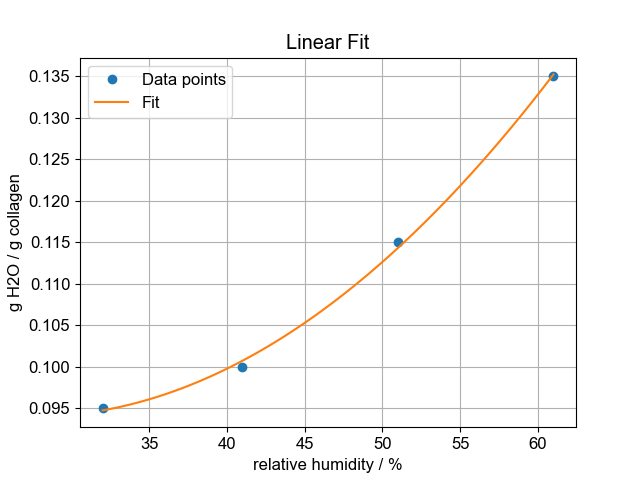

In [11]:
# Plot the conversion from relative humidity to water content in fibrils:

# Plot copyied from:
# Stabilization and Anomalous Hydration of Collagen Fibril under Heating
# DOI:10.1371/journal.pone.0078526

# Data points
x = np.array([32, 41, 51, 61])
y = np.array([0.095, 0.1, 0.115, 0.135])

# Perform linear fit (1st-degree polynomial)
coeffs = np.polyfit(x, y, 2)  # returns [slope, intercept]

# Create fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = np.polyval(coeffs,x_fit)


# Plot
fig,ax = plt.subplots()
ax.plot(x, y, 'o', label='Data points')
ax.plot(x_fit, y_fit, '-', label=f'Fit')
ax.set_xlabel('relative humidity / %')
ax.set_ylabel('g H2O / g collagen')
ax.legend()
ax.set_title('Linear Fit')
ax.grid(True)
plt.show()




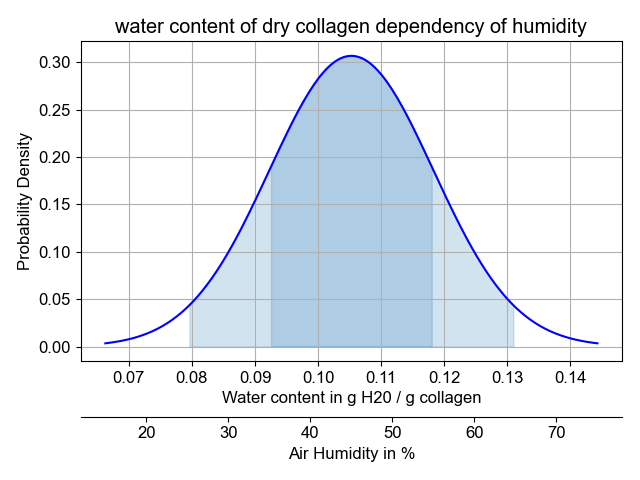

In [12]:
## Plot a probability curve of humidity 
# and for the density of dry collagen

# Define parameters
mu2, sigma2 = 45, 10
mu1, sigma1 = np.polyval(coeffs,mu2), 0.013 # Estimation 


# x values
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 200)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 200)

# Gaussian functions
y1 = (0.01 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-(x1 - mu1)**2 / (2 * sigma1**2))
y2 = (0.01 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-(x2 - mu2)**2 / (2 * sigma2**2))

# Create figure and first axis
fig, ax1 = plt.subplots()

# Plot first Gaussian
ax1.plot(x1, y1, label=f'$\mu={mu1}$, $\sigma={sigma1}$', color='blue')
ax1.set_xlabel('Water content in g H20 / g collagen')
ax1.set_ylabel('Probability Density')
ax1.grid()

# Define the transformation between x1 and x2
scale = sigma2/sigma1  # ≈ 6.6667

def x1_to_x2(x):
    return scale * (x - mu1) + mu2

def x2_to_x1(x2):
    return (x2 - mu2) / scale + mu1

# Create second axis — **but manually adjust its position**
ax2 = ax1.secondary_xaxis('bottom', functions=(x1_to_x2, x2_to_x1))

# Move secondary x-axis downward
ax2.spines['bottom'].set_position(('outward', 40))  # move 40 points downward
ax2.set_xlabel('Air Humidity in %')

# Plot second curve
x2_as_x1 = x2_to_x1(x2)
ax1.plot(x2_as_x1, y2, label=f'$\mu={mu2}$, $\sigma={sigma2}$', 
         color='red',alpha=0, linestyle='--')


# 
# Fill between -1σ and +1σ for the first curve (humidity)
x1_fill = x1[(x1 >= mu1 - sigma1) & (x1 <= mu1 + sigma1)]
y1_fill = y1[(x1 >= mu1 - sigma1) & (x1 <= mu1 + sigma1)]
ax1.fill_between(x1_fill, y1_fill, alpha=0.2, color='C0')

x1_fill = x1[(x1 >= mu1 - 2*sigma1) & (x1 <= mu1 + 2*sigma1)]
y1_fill = y1[(x1 >= mu1 - 2*sigma1) & (x1 <= mu1 + 2*sigma1)]
ax1.fill_between(x1_fill, y1_fill, alpha=0.2, color='C0')

plt.title('water content of dry collagen dependency of humidity')
plt.tight_layout()
plt.show()

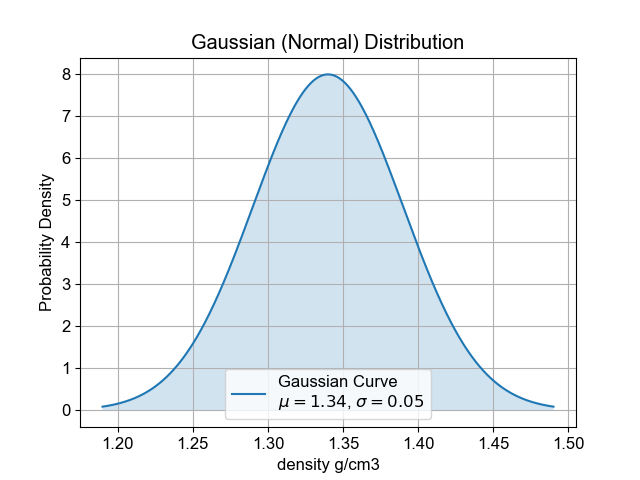

In [13]:
# Density estimation of callagen fibrils:
# From:Fibrillar structure and elasticity of hydrating collagen: A quantitative multiscale approach$
# Claire Morin, Christian Hellmich n, Peter Henits

# http://dx.doi.org/10.1016/j.jtbi.2012.09.026

# Density estimated to be 1.34 ± 0.03 g/cm3

# Define parameters
mu = 1.34       # Mean
sigma = 0.05    # Standard deviation

# Generate x values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# Define the Gaussian function manually
y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Plot the curve
fig,ax = plt.subplots()
ax.plot(x, y, label=f'Gaussian Curve\n$\mu={mu}$, $\sigma={sigma}$')
ax.fill_between(x, y, alpha=0.2)
ax.set_title('Gaussian (Normal) Distribution')
ax.set_xlabel('density g/cm3')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid()
plt.show()



# Calculate the swelling due to water uptake for our data 

In [14]:
## Calculate the error of the humidy calculation

# Using the values calculated from before:


# how many datapoints to calc:
dp = 1000 # default:10000
df_test = df_AFM.copy()

# For the density:
mu_d = 1.34       # 1.34 Mean
sigma_d = 0.03    # 0.03 Standard deviation
d_values = np.random.normal(mu_d, sigma_d, dp) # create random values


# For the water content in dry fibrils:
mu_wc = 0.105 # 0.10528 Mean
sigma_wc = 0.05 #0.05 Standard deviation
wc_values = np.random.normal(mu_wc, sigma_wc, dp) # create random values


R = []

for k in range(len(d_values)):
    
    fm_dry = 1             # fibril mass in g
    wm_dry = wc_values[k]          # water mass in g
    cm_dry = fm_dry-wm_dry # collagen mass in g

    # densities
    # density of tropocollagen between 1.34−1.40 g/cm3
    rc = d_values[k] # default: 1.37 g/ml
    rw = 0.997770 # in g/mL


    fv_dry = 1 # ml
    factor = 1/((wm_dry/rw)+(cm_dry/rc))
    wv_dry = round((wm_dry/rw)*factor,2)
    cv_dry = round((cm_dry/rc)*factor,2)

    # Calculate all the parameters:
    Cw_dry,ng_dry, Cw_wet, ng_wet, A_dry_list, A_wet_list = calc_cw_ng(df_test['D_area_simpson_AFM'],df_test['W_area_simpson_AFM'])
    R += [ng_wet]

In [15]:
R_transposed = [list(pair) for pair in zip(*R)]
sigma_R = [np.std(r) for r in R_transposed]
df_test['sigma_n_theo'] = sigma_R

# eliminate the rows with nan
valid_data = df_test[['A_Swell', 'n_intersect', 'fibril','n_theroy']].dropna()

(0.65, 0.8245004323851655)

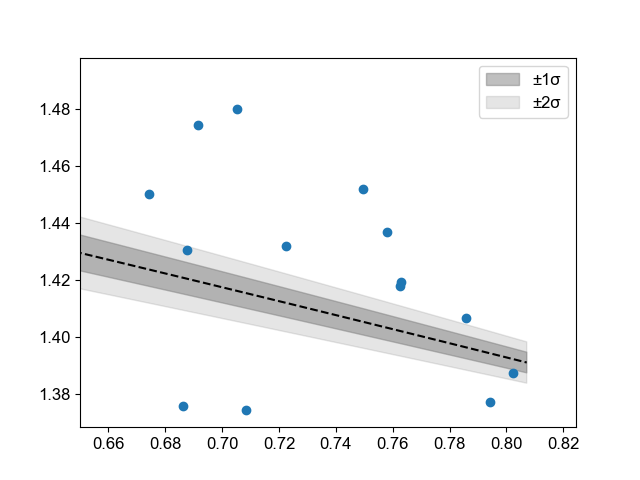

In [16]:
# Plot the curve
df_test = df_test.sort_values('H2O_swell')
fig,ax = plt.subplots()
ax.plot(df_test['H2O_swell'], df_test['n_theroy'],color='black',linestyle='--')

# ax.errorbar(df_test['H2O_swell'],df_test['n_theroy'],
#             df_test['sigma_n_theo'],fmt ='o',capsize=5,markersize=10,
#             color='k',alpha=0.3,marker = '.')
# Add the ±sigma fill
ax.fill_between(df_test['H2O_swell'],
                df_test['n_theroy'] - df_test['sigma_n_theo'],
                df_test['n_theroy'] + df_test['sigma_n_theo'],
                color='gray', alpha=0.5, label='±1σ')

ax.fill_between(df_test['H2O_swell'],
                df_test['n_theroy'] - 2*df_test['sigma_n_theo'],
                df_test['n_theroy'] + 2*df_test['sigma_n_theo'],
                color='gray', alpha=0.2, label='±2σ')
ax.legend()
ax.scatter(df_test['H2O_swell'], df_test['n_intersect'])
ax.set_xlim(0.65)

In [1]:
# Overview of our results

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# List of x-axis values and labels for the subplots
x_values = ['A_Swell', 'H_Swell', 'W_swell', 'H2O_swell']
x_labels = ['A_Swell / %', 'H_Swell / %', 'W_swell / %', 'H2O_swell / %']

# Flatten the axes array to iterate over them easily
axs = axs.flatten()
# Loop through each subplot and plot the corresponding scatter plot
for i, x_val in enumerate(x_values):
    print(x_val)
    axs[i].scatter(df_AFM[x_val], df_AFM['n_intersect'], label=f'n_intersect vs {x_values[i]}')
    axs[i].set_xlabel(x_labels[i])
    axs[i].set_ylabel('n_intersect')
    axs[i].set_title(f'{x_values[i]} vs n_intersect')
    valid_data = df_AFM[[x_val, 'n_intersect', 'fibril']].dropna()

    
    # Add the ROI Labels:
    for x, y, fibril_label in zip(valid_data[x_val], valid_data['n_intersect'], valid_data['fibril']):
        axs[i].text(x, y, f"{fibril_label}", fontsize=6, ha='right', va='bottom')
    axs[i].grid(True)


# Adjust the layout for better spacing between subplots
plt.tight_layout()
fig.savefig('Comparing_results/n_swelling.png',dpi=500)

NameError: name 'plt' is not defined

Text(0, 0.5, 'RI')

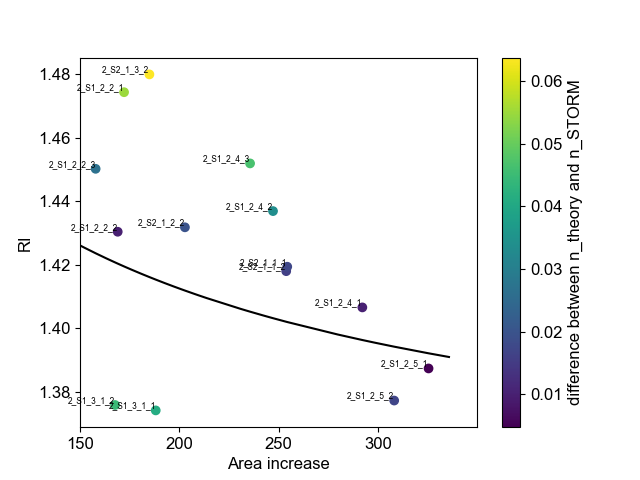

In [18]:
fig, ax = plt.subplots()
scat1 = ax.scatter(df_AFM['A_Swell'],df_AFM['n_intersect'],
           c=abs(df_AFM['n_intersect']-df_AFM['n_theroy']))
plt.colorbar(scat1,label = 'difference between n_theory and n_STORM')

# Add a linear fit to the data:
columns_to_check = ['A_Swell', 'n_intersect']  
filtered_df = df_AFM.dropna(subset=columns_to_check)

xD = list(filtered_df['A_Swell'])
yD = list(filtered_df['n_intersect'])

# fit_lin = np.polyfit(xD,yD,1)
# x_fit = np.linspace(0.65,0.8,10)
# y_fit = np.polyval(fit_lin,x_fit)
# ax.plot(x_fit,y_fit,c='r',label = 'linear fit')

# # Add the ROI Labels:
valid_data = df_AFM[['A_Swell', 'n_intersect', 'fibril']].dropna()
for x, y, fibril_label in zip(valid_data['A_Swell'], valid_data['n_intersect'], valid_data['fibril']):
    ax.text(x, y, f"{fibril_label}", fontsize=6, ha='right', va='bottom')
    
# Add the theoretical values:
df_AFM = df_AFM.sort_values(by='A_Swell')
ax.plot(df_AFM['A_Swell'],df_AFM['n_theroy'],color='k',label = 'theoretical curve')
ax.set_xlim(150)
ax.set_xlabel('Area increase')
ax.set_ylabel('RI')

# import numpy as np


# ax.legend()

Text(0, 0.5, 'RI')

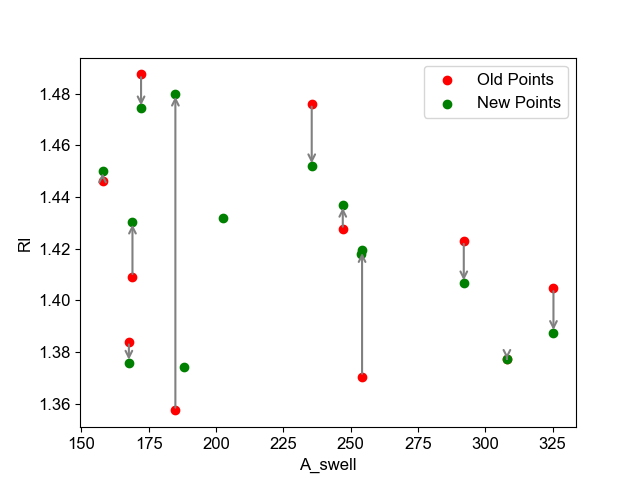

In [19]:
## Load previous results:
df_new = df_AFM.copy()

df_old = pd.read_csv('/Users/simonjaritz/Desktop/MID_LAYER/Comparing_results/df_AFM_MID_LAYER_.csv')
df_old_filtered = df_old[df_old['A_Swell'].isin(df_new['A_Swell'])]



# Create a figure with 4 subplots
fig, ax = plt.subplots()
ax.scatter(df_old_filtered['A_Swell'], df_old_filtered['n_intersect'], color='red', label='Old Points')
ax.scatter(df_new['A_Swell'], df_new['n_intersect'], color='green', label='New Points')

# # Draw lines connecting old and new points




for _, row in df_old_filtered.iterrows():
    matching_new_row = df_new[df_new['A_Swell'] == row['A_Swell']].dropna(subset=['A_Swell', 'n_intersect'])

    if not matching_new_row.empty:
        x_old, y_old = row['A_Swell'], row['n_intersect']

        # Ensure at least one valid row exists
        if len(matching_new_row) > 0:
            x_new, y_new = matching_new_row.iloc[0][['A_Swell', 'n_intersect']]

            # Ensure values are valid before plotting
            if not (np.isnan(x_old) or np.isnan(y_old) or np.isnan(x_new) or np.isnan(y_new)):
                ax.annotate("",
                            xy=(x_new, y_new), xytext=(x_old, y_old),
                            arrowprops=dict(arrowstyle="->", color='gray', lw=1.5))
#                 ax.scatter(x_old,y_old,color='r',label = 'old_points')



ax.legend()
ax.set_xlabel('A_swell')
ax.set_ylabel('RI')

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/4081440563.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/4081440563.py:73: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


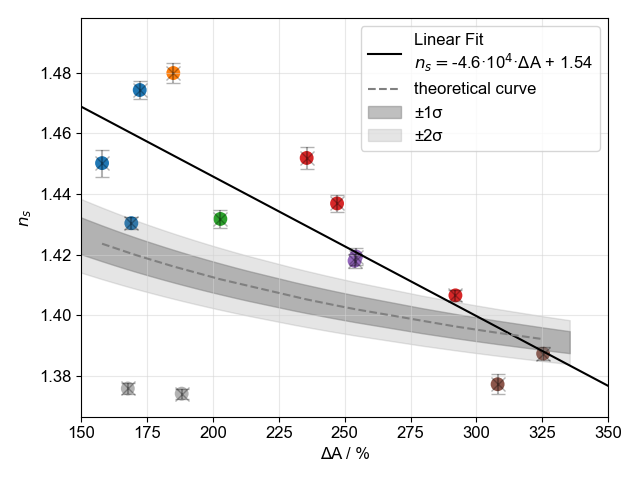

In [21]:
fibrils_filter_out = ['2_S1_3', '2_S5_1', '2_S4_3'] 
# Fibril Nr. 2_S1_3 has been identified as an outlier 

df = df_AFM.copy()
df = df.dropna(subset=['n_intersect'])

# Filter the DataFrame
df_outliers = df[df['fibril'].str.contains('2_S1_3', case=False, na=False)]
df_filtered = df[~df['fibril'].str.contains('|'.join(fibrils_filter_out), 
                                            case=False, na=False)]
df_filtered = df_filtered.sort_values('A_Swell')

xD = list(df_filtered['A_Swell'])
yD = list(df_filtered['n_intersect'])
fit_lin = np.polyfit(xD,yD,1)
x_fit = np.linspace(150,350,10)
y_fit = np.polyval(fit_lin,x_fit)



# Just for plotting:
fit_list = fit_lin.copy()
fit_list[0] = fit_list[0]*1e4 
fit_list = [round(float(j),2) for j in fit_list]
fit_list = [str(j) for j in fit_list]
fit_list[0] = fit_list[0]+'·10$^4$'
fit_list = f'$n_s = ${fit_list[0]}·ΔA + {fit_list[1]}'



# Extract grouping key (everything except the last digit)
df_filtered['group'] = df_filtered['fibril'].str.rsplit('_', n=1).str[0]

# Generate a color palette
unique_groups = df_filtered['group'].unique()
palette = dict(zip(unique_groups, sns.color_palette("tab10", len(unique_groups))))

errorbars = df_filtered['std_n_r']
    
# The plot:
fig, ax = plt.subplots()
ax.grid(color='lightgrey',alpha = 0.5)
# for group, data in df_filtered.groupby('group'):
#     scat1 = ax.scatter(df_filtered['A_Swell'],df_filtered['n_intersect'], 
#                        label=group, color=palette[group])
    
# scat1 = ax.scatter(df_filtered['A_Swell'],df_filtered['n_intersect'],
#                    color = 'red',edgecolors='k',label = 'Different Cross Sections')

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax.scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)



# Plotting the errorbars
ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

ax.plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
       fit_list)
ax.set_xlabel('ΔA / %')
ax.set_ylabel('$n_s$')

# Plotting the outliers:
ax.scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

# ax.set_xlabel('Relatve Cross Section Area Change / %')

# # 
# # # Add the ROI Labels:
# valid_data = df_filtered[['A_Swell', 'n_intersect', 'fibril']].dropna()
# for x, y, fibril_label in zip(valid_data['A_Swell'], valid_data['n_intersect'], valid_data['fibril']):
#     ax.text(x, y, f"{fibril_label}", fontsize=6, ha='right', va='bottom')
    
# Add the theoretical values:
df_filtered = df_filtered.sort_values(by='A_Swell')
ax.plot(df_filtered['A_Swell'],df_filtered['n_theroy'],color='grey',
        linestyle = '--',label = 'theoretical curve')

ax.fill_between(df_test['A_Swell'],
                df_test['n_theroy'] - df_test['sigma_n_theo'],
                df_test['n_theroy'] + df_test['sigma_n_theo'],
                color='gray', alpha=0.5, label='±1σ')

ax.fill_between(df_test['A_Swell'],
                df_test['n_theroy'] - 2*df_test['sigma_n_theo'],
                df_test['n_theroy'] + 2*df_test['sigma_n_theo'],
                color='gray', alpha=0.2, label='±2σ')
ax.set_xlim(150,350)

# if (min(df_filtered['n_intersect']) > 1.37) & (max(df_filtered['n_intersect'])<1.48):
#     ax.set_ylim(1.37,1.49)
ax.legend()
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling.png',dpi = 600)

In [22]:
# Overall error of the method to calculate the RI:
print(np.round(np.median(np.concatenate([df_outliers['std_n_r'].values, df_filtered['std_n_r'].values])),4))


0.0028


In [24]:
df_test_extended = df_filtered.copy()
df_test_extended['n_theo_154'] = get_ng(df_test_extended['H2O_swell'],1.54)
df_test_extended['n_theo_157'] = get_ng(df_test_extended['H2O_swell'],1.57)
df_test_extended['n_theo_160'] = get_ng(df_test_extended['H2O_swell'],1.60)
df_test_extended['n_theo_163'] = get_ng(df_test_extended['H2O_swell'],1.63)

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/832223691.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/832223691.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


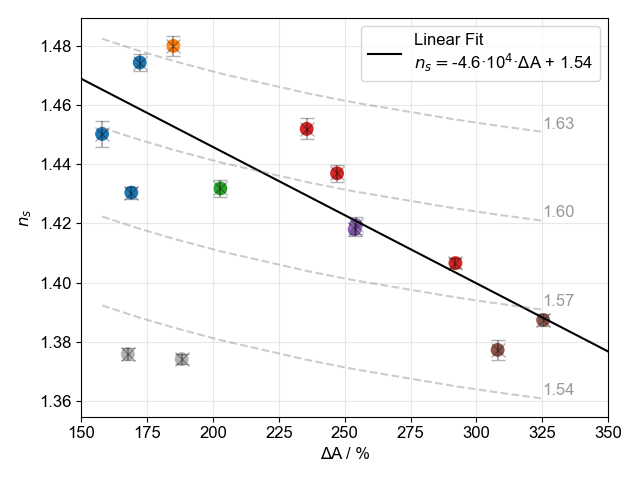

In [25]:

    
# The plot:
fig, ax = plt.subplots()
ax.grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax.scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

ax.plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
       fit_list)
ax.set_xlabel('ΔA / %')
ax.set_ylabel('$n_s$')

# Plotting the outliers:
ax.scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')
    
# Add the theoretical values:
df_test_extended = df_test_extended.sort_values(by='A_Swell')
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_154'],color='grey',
        linestyle = '--',alpha=0.4)
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_157'],color='grey',
        linestyle = '--',alpha=0.4)
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_160'],color='grey',
        linestyle = '--',alpha=0.4)
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_163'],color='grey',
        linestyle = '--',alpha=0.4)

ax.text(325,1.362,'1.54',color='grey',alpha=0.8)
ax.text(325,1.392,'1.57',color='grey',alpha=0.8)
ax.text(325,1.422,'1.60',color='grey',alpha=0.8)
ax.text(325,1.452,'1.63',color='grey',alpha=0.8)

ax.set_xlim(150,350)
ax.legend()
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling.png',dpi = 600)

In [26]:
# Using col_dry formula:
def col_dry_lines(n_dry,n_H2O = 1.33):
    dA = np.linspace(150,325,100)
    n_col = (n_dry + dA*n_H2O/100)/(1+dA/100)
    return dA,n_col



/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/341503268.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/341503268.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


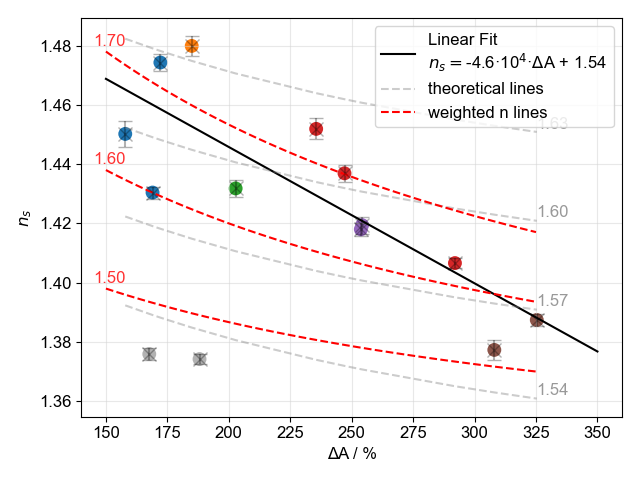

In [27]:
# The plot:
fig, ax = plt.subplots()
ax.grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax.scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax.errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

ax.plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
       fit_list)
ax.set_xlabel('ΔA / %')
ax.set_ylabel('$n_s$')

# Plotting the outliers:
ax.scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax.errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')
    
# Add the theoretical values:
df_test_extended = df_test_extended.sort_values(by='A_Swell')
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_154'],color='grey',
        linestyle = '--',alpha=0.4,label = 'theoretical lines')
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_157'],color='grey',
        linestyle = '--',alpha=0.4)
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_160'],color='grey',
        linestyle = '--',alpha=0.4)
ax.plot(df_test_extended['A_Swell'],df_test_extended['n_theo_163'],color='grey',
        linestyle = '--',alpha=0.4)

ax.text(325,1.362,'1.54',color='grey',alpha=0.8)
ax.text(325,1.392,'1.57',color='grey',alpha=0.8)
ax.text(325,1.422,'1.60',color='grey',alpha=0.8)
ax.text(325,1.452,'1.63',color='grey',alpha=0.8)


# Add col_dry lines:

d_vary,ncol = col_dry_lines(1.5,n_H2O = 1.33)
ax.plot(d_vary,ncol,'r',linestyle = '--',label = 'weighted n lines')
d_vary,ncol = col_dry_lines(1.6,n_H2O = 1.33)
ax.plot(d_vary,ncol,'r',linestyle = '--')
d_vary,ncol = col_dry_lines(1.7,n_H2O = 1.33)
ax.plot(d_vary,ncol,'r',linestyle = '--')

ax.text(145,1.4,'1.50',color='red',alpha=0.8)
ax.text(145,1.44,'1.60',color='red',alpha=0.8)
ax.text(145,1.48,'1.70',color='red',alpha=0.8)

# ax.set_xlim(150,350)
ax.legend()
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling_red_lines.png',dpi = 600)

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/2110168076.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers['n_dry_G'] = df_outliers['n_intersect'] * swell_factor - swell_correction
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/2110168076.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(df_filtered['D_area_simpson_AFM'],df_filtered['n_dry_G'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/2110168076.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will tak

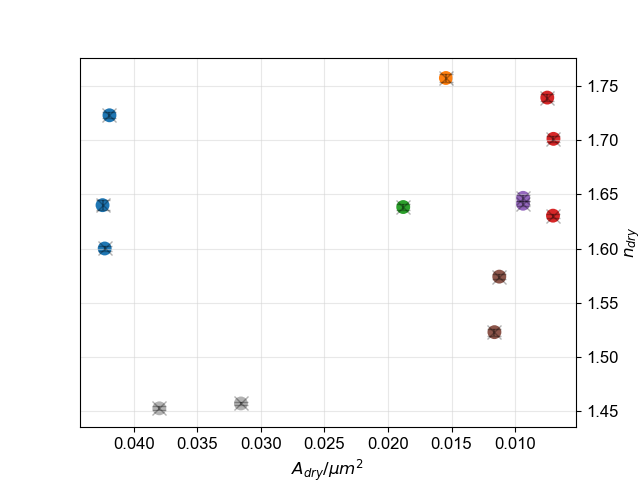

In [28]:
swell_factor = 1 + df_filtered['A_Swell'] / 100
swell_correction = 1.33 * df_filtered['A_Swell'] / 100
df_filtered['n_dry_G'] = df_filtered['n_intersect'] * swell_factor - swell_correction

swell_factor = 1 + df_outliers['A_Swell'] / 100
swell_correction = 1.33 * df_outliers['A_Swell'] / 100
df_outliers['n_dry_G'] = df_outliers['n_intersect'] * swell_factor - swell_correction


# The plot:
fig, ax = plt.subplots()
ax.grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax.scatter(df_filtered['D_area_simpson_AFM'].iloc[k],
               df_filtered['n_dry_G'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax.errorbar(df_filtered['D_area_simpson_AFM'],df_filtered['n_dry_G'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')
ax.set_xlabel('$A_{dry} / µm^2$')
ax.set_ylabel('$n_{dry}$')

# Plotting the outliers:
ax.scatter(df_outliers['D_area_simpson_AFM'].iloc[0:],
               df_outliers['n_dry_G'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax.errorbar(df_outliers['D_area_simpson_AFM'],df_outliers['n_dry_G'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')


ax.invert_xaxis()
ax.yaxis.tick_right()    # Move ticks to the right
ax.yaxis.set_label_position("right")  # Move y-axis label to the right

# ax.set_xlim(150,350)
fig.savefig('Comparing_results/plot_Adry_vs_ndry.png',dpi = 600)

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1946118251.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1946118251.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


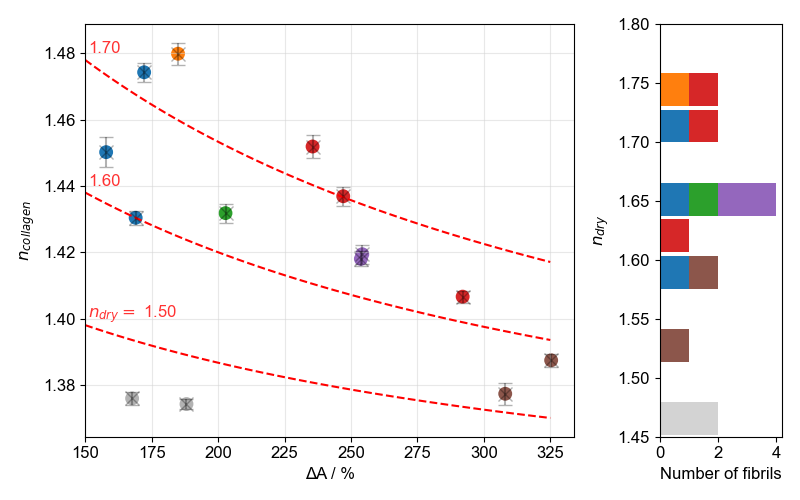

In [29]:
### combine the normal df with the outliers
df_visual = pd.concat([df_filtered,df_outliers], ignore_index=True)



# The plot:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]},
                      figsize = (8,5))
ax[0].grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax[0].scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

# ax[0].plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
#        fit_list)
ax[0].set_xlabel('ΔA / %')
ax[0].set_ylabel('$n_{collagen}$')

# Plotting the outliers:
ax[0].scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')


# Add col_dry lines:

d_vary,ncol = col_dry_lines(1.5,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--',label = 'weighted n lines')
d_vary,ncol = col_dry_lines(1.6,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')
d_vary,ncol = col_dry_lines(1.7,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')

ax[0].set_xlim(150)
ax[0].text(151,1.4,'$n_{dry} = $ 1.50',color='red',alpha=0.8)
ax[0].text(151,1.44,'1.60',color='red',alpha=0.8)
ax[0].text(151,1.48,'1.70',color='red',alpha=0.8)

# ax[0].set_xlim(150,350)
# ax[0].legend()

# ax[1].hist(df_visual['n_dry_G'],bins = 10, alpha = 0.4,color= 'grey',
#         range = [1.45,1.75],orientation='horizontal')

ax[0].grid(color='lightgrey',alpha = 0.5)
# Extract data to histogram
data = df_visual['n_dry_G']
nbins = 10
bin_range = (1.45, 1.76)
bins = np.linspace(*bin_range, nbins+1)

# Digitize the data to find which bin each point belongs to
bin_indices = np.digitize(data, bins) - 1  # shift to 0-based



for i in range(nbins):
    bin_center = 0.5 * (bins[i] + bins[i+1])
    points_in_bin = np.where(bin_indices == i)[0]
    
    for j, idx in enumerate(points_in_bin):
        group = df_visual.iloc[idx]['group']
        if pd.isna(group):
            color = 'lightgrey'
        else:
            color = palette.get(group, 'black')  # fallback in case group not in palette
        ax[1].barh(bin_center, width=1, height=(bins[1] - bins[0])*0.9,
                   left=j, color=color, edgecolor='none')

ax[1].set_xlabel('Number of fibrils')
ax[1].set_ylabel('$n_{dry}$')
ax[1].set_xticks([0, 2, 4])
ax[1].set_ylim(1.45,1.80)
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling_only_red_lines_colorbars.png',
            dpi = 600)

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1226015481.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1226015481.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


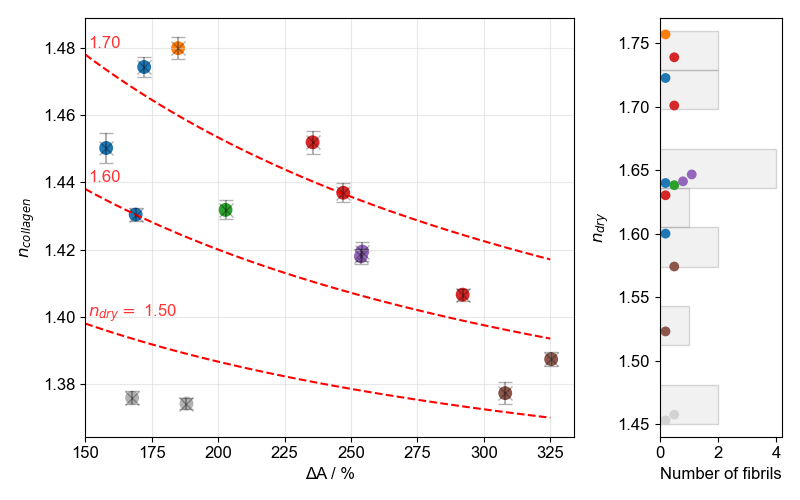

In [42]:
### combine the normal df with the outliers
df_visual = pd.concat([df_filtered,df_outliers], ignore_index=True)



# The plot:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]},
                      figsize = (8,5))
ax[0].grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax[0].scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

# ax[0].plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
#        fit_list)
ax[0].set_xlabel('ΔA / %')
ax[0].set_ylabel('$n_{collagen}$')

# Plotting the outliers:
ax[0].scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')


# Add col_dry lines:

d_vary,ncol = col_dry_lines(1.5,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--',label = 'weighted n lines')
d_vary,ncol = col_dry_lines(1.6,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')
d_vary,ncol = col_dry_lines(1.7,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')

ax[0].set_xlim(150)
ax[0].text(151,1.4,'$n_{dry} = $ 1.50',color='red',alpha=0.8)
ax[0].text(151,1.44,'1.60',color='red',alpha=0.8)
ax[0].text(151,1.48,'1.70',color='red',alpha=0.8)

# ax[0].set_xlim(150,350)
# ax[0].legend()

# ax[1].hist(df_visual['n_dry_G'],bins = 10, alpha = 0.4,color= 'grey',
#         range = [1.45,1.75],orientation='horizontal')

ax[0].grid(color='lightgrey',alpha = 0.5)
# Extract data to histogram
data = df_visual['n_dry_G']
nbins = 10
bin_range = (1.45, 1.76)
bins = np.linspace(*bin_range, nbins+1)

# Digitize the data to find which bin each point belongs to
bin_indices = np.digitize(data, bins) - 1  # shift to 0-based


ax[1].hist(data, bins=10, range=(1.45, 1.76), orientation='horizontal',
           color='lightgrey', edgecolor='grey', alpha=0.3)

for i in range(nbins):
    bin_center = 0.5 * (bins[i] + bins[i+1])
    points_in_bin = np.where(bin_indices == i)[0]
    n_points = len(points_in_bin)
    spacing = 0.3  # adjust dot spacing here

    for j, idx in enumerate(points_in_bin):
        group = df_visual.iloc[idx]['group']
        position_hist = df_visual.iloc[idx]['n_dry_G']
        if pd.isna(group):
            color = 'lightgrey'
        else:
            color = palette.get(group, 'black')

        # Stack horizontally using spacing
        x_pos = (j * spacing)+0.2
   
        ax[1].scatter(x_pos, position_hist, s=50, color=color, edgecolor='none')
        
# for i in range(nbins):
#     bin_center = 0.5 * (bins[i] + bins[i+1])
#     points_in_bin = np.where(bin_indices == i)[0]
    
#     for j, idx in enumerate(points_in_bin):
#         group = df_visual.iloc[idx]['group']
#         position_hist = df_visual.iloc[idx]['n_dry_G']
#         if pd.isna(group):
#             color = 'lightgrey'
#         else:
#             color = palette.get(group, 'black')  # fallback in case group not in palette
#         ax[1].scatter(j + 0.5, position_hist, s=50, color=color, edgecolor='none') 


ax[1].set_xlabel('Number of fibrils')
ax[1].set_ylabel('$n_{dry}$')
ax[1].set_xticks([0, 2, 4])
ax[1].set_ylim(1.44,1.77)
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling_only_red_lines_colorDots.png',dpi = 600)

/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1455597227.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_42520/1455597227.py:33: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],


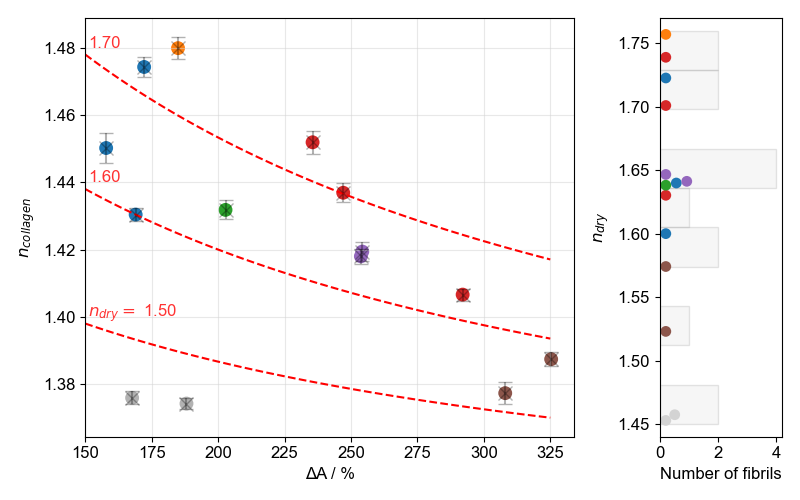

In [93]:
### combine the normal df with the outliers
df_visual = pd.concat([df_filtered,df_outliers], ignore_index=True)



# The plot:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]},
                      figsize = (8,5))
ax[0].grid(color='lightgrey',alpha = 0.5)

# Plotting the datapoints
for k in range(len(df_filtered)):
    ax[0].scatter(df_filtered['A_Swell'].iloc[k],
               df_filtered['n_intersect'].iloc[k],
               color = palette[df_filtered['group'].iloc[k]],
               edgecolors='none',s=100)

# Plotting the errorbars
ax[0].errorbar(df_filtered['A_Swell'],df_filtered['n_intersect'],
            errorbars,fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')

# ax[0].plot(x_fit,y_fit,c='k',linestyle = '-',label = 'Linear Fit\n'+
#        fit_list)
ax[0].set_xlabel('ΔA / %')
ax[0].set_ylabel('$n_{collagen}$')

# Plotting the outliers:
ax[0].scatter(df_outliers['A_Swell'].iloc[0:],
               df_outliers['n_intersect'].iloc[0:],
               color = 'grey',alpha = 0.6,
               edgecolors='none',s=100)
ax[0].errorbar(df_outliers['A_Swell'],df_outliers['n_intersect'],
            df_outliers['std_n_r'],fmt ='o',capsize=5,markersize=10,
            color='k',alpha=0.3,marker = 'x')


# Add col_dry lines:

d_vary,ncol = col_dry_lines(1.5,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--',label = 'weighted n lines')
d_vary,ncol = col_dry_lines(1.6,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')
d_vary,ncol = col_dry_lines(1.7,n_H2O = 1.33)
ax[0].plot(d_vary,ncol,'r',linestyle = '--')

ax[0].set_xlim(150)
ax[0].text(151,1.4,'$n_{dry} = $ 1.50',color='red',alpha=0.8)
ax[0].text(151,1.44,'1.60',color='red',alpha=0.8)
ax[0].text(151,1.48,'1.70',color='red',alpha=0.8)

# ax[0].set_xlim(150,350)
# ax[0].legend()

# ax[1].hist(df_visual['n_dry_G'],bins = 10, alpha = 0.4,color= 'grey',
#         range = [1.45,1.75],orientation='horizontal')

ax[0].grid(color='lightgrey',alpha = 0.5)
# Extract data to histogram
data = df_visual['n_dry_G']
nbins = 10
bin_range = (1.45, 1.76)
bins = np.linspace(*bin_range, nbins+1)

# Digitize the data to find which bin each point belongs to
bin_indices = np.digitize(data, bins) - 1  # shift to 0-based


ax[1].hist(data, bins=10, range=(1.45, 1.76), orientation='horizontal',
           color='lightgrey', edgecolor='grey', alpha=0.2)



    
from collections import defaultdict
dot_spacing = 0.36  # horizontal spacing between dots
min_y_dist = 0.005  # minimum vertical distance to consider two dots "too close"

for i in range(nbins):
    # Get points in this bin
    points_in_bin = np.where(bin_indices == i)[0]
    
    # Sort these points by y-position
    sorted_points = sorted(points_in_bin, key=lambda idx: df_visual.iloc[idx]['n_dry_G'])
    
    y_used = []

    for idx in sorted_points:
        y_val = df_visual.iloc[idx]['n_dry_G']
        group = df_visual.iloc[idx]['group']
        color = 'lightgrey' if pd.isna(group) else palette.get(group, 'black')
        
        # Check how many existing points are close in y
        offset = sum(abs(y_val - y) < min_y_dist for y in y_used)
        
        # Compute minimum y-distance BEFORE adding current point
        min_dist = min([abs(y_val - y) for y in y_used], default=np.inf)

        # Apply reduced spacing if sufficiently spaced from others
        spacing_factor = 0.85 if min_dist > (0.4 * min_y_dist) else 1.0

        # Apply adjusted horizontal offset
        x_pos = (offset * dot_spacing * spacing_factor) + 0.21
        
        ax[1].scatter(x_pos, y_val, s=60, color=color, edgecolor='none')
        
        # Now add to used list
        y_used.append(y_val)
    


ax[1].set_xlabel('Number of fibrils')
ax[1].set_ylabel('$n_{dry}$')
ax[1].set_xticks([0, 2, 4])
ax[1].set_ylim(1.44,1.77)
plt.tight_layout()
fig.savefig('Comparing_results/nc_DA_overview_resampling_only_red_lines_colorDots.png',dpi = 600)